# Travelling salesman problem - algorithm comparison

**Imports**

In [1]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

## **Implementation**

**Generating a graph - cities**

In [2]:
random.seed(12345)
cities = []
num_cities = 10
for i in range (0,num_cities):
  cities.append([i, random.uniform(-100,100), random.uniform(-100,100), random.uniform(0,50)])   #pierwszy element to identyfikator naszego miasta

C:\Users\marta\AppData\Local\Temp\ipykernel_2888\456072121.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(df[1], df[2], df[3], cmap='Greens', s=200)


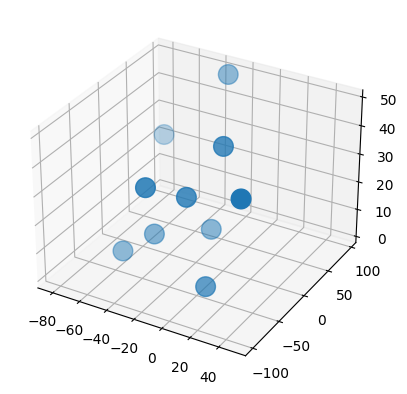

In [3]:
df = pd.DataFrame(cities)

ax = plt.axes(projection='3d')
ax.scatter3D(df[1], df[2], df[3], cmap='Greens', s=200)

**Generating a graph - calculating distances**

In [4]:
def euclidean(point1, point2, sym):
  #function measures the distance just from point 1 to point 2, not both directions
  #point has to be presented as a list: [x, y, z]
  #sym = True/False    if the problem is symmetrical or asymmetrical

  euclidean = ((point1[1]-point2[1])**2 + (point1[2]-point2[2])**2 + (point1[3]-point2[3])**2)**(1/2)

  if sym == True:
    return euclidean
  elif sym == False:
    if point2[2]>point1[2]:
      return euclidean*1.1
    elif point2[2]<point1[2]:
      return euclidean*0.9
    else:
      return euclidean

**Creating a graph - final step**

In [5]:
def create_graph(nodes, conn, sym):
  #function creates the directed graph, connects nodes with each other with weighted edges (using euclidean function)
  #conn is a number (0,1] - indicates how much % of possible connections we want to implement
  #sym = True/False    if the problem is symmetrical or asymmetrical - this argument will be forwarded to euclidean function

  poss_conn_num = len(nodes) * (len(nodes) - 1)   #number of all possible connections

  if conn > 1 or conn <= 0: raise ValueError

  edges = []

  for k in range (0, len(nodes)):
    for i in range (0, len(nodes)):
      if i != k:
        edges.append([nodes[k], nodes[i], euclidean(nodes[k], nodes[i], sym)])

  if conn <= 1 and conn > 0: 
    rem_conn_num = round(poss_conn_num*(1-conn))     #number of paths we need to remove
    for i in range (0, rem_conn_num):
      del edges[random.randrange(0, len(edges))]
  
  return edges

In [6]:
graph = create_graph(cities, 1, False)

**BFS & DFS**

In [13]:
def bfs_paths(departure_point):

  start = departure_point

  queue = deque()
  queue.append([[start], 0])

  while len(queue)!=0 and len(queue[0][0])<len(cities):

    curr = queue.popleft()
    start = curr[0][-1]

    visited = set(curr[0])
    
    for path in graph:
      if path[0][0] == start and path[1][0] not in visited:
        route = curr[0].copy() 
        route.append(path[1][0])
        dist = curr[1] + path[2]
        queue.append([route, dist])

  for path in graph:
    if path[1][0] == departure_point:
      for resolution in queue:
        if resolution[0][-1]==path[0][0]:
          resolution[0].append(departure_point)
          resolution[1] = resolution[1] + path[2]

  for resolution in deque(queue):
    if len(resolution[0]) <= len(cities):
      queue.remove(resolution)

  if len(queue) != 0:
    return pd.DataFrame(queue).sort_values(by=1).head(1)
  else:
    return "Brak wyników"

In [60]:
def dfs_paths(departure_point):

  start = departure_point

  res=[]

  stack = []
  stack.append([[start], 0])

  while len(stack)!=0:
    curr = stack.pop()
    start = curr[0][-1]

    visited = set(curr[0])

    childcounter = 0
    for path in graph:
      if path[0][0] == start and path[1][0] not in visited:
        route = curr[0].copy() 
        route.append(path[1][0])
        dist = curr[1] + path[2]
        stack.append([route, dist])
        childcounter += 1
    
    if childcounter == 0:
      if len(curr[0]) == len(cities):
        res.append(curr)

  for path in graph:
    if path[1][0] == departure_point:
      for resolution in res:
        if resolution[0][-1]==path[0][0]:
          resolution[0].append(citystart)
          resolution[1] = resolution[1] + path[2]

  for resolution in list(res):
    if len(resolution[0]) <= len(cities):
      res.remove(resolution)

  if len(res) != 0:
    return pd.DataFrame(res).sort_values(by=1).head(1)
  else:
    return "No results"

**Greedy NN and greedy modified (second nearest neighbour)**

In [61]:
def greedy_nn(departure_point):
  start = departure_point
  nn_path = [[start], 0]
  no_way_flag = False
  
  while len(nn_path[0])<len(cities):
    visited = set(nn_path[0])
    nndist = [[], 100000]
    for path in graph:
      if path[0][0] == start and path[1][0] not in visited:
        if path[2] < nndist[1]: 
          nndist = [path[1][0], path[2]]
    nn_path[0].append(nndist[0])
    nn_path[1] = nn_path[1] + nndist[1]
    start = nndist[0]
    #print(nn_path[0])
    if nn_path[0][-1] == []:
      no_way_flag = True        #there is no further connection and we cannot create a full cycle (because still not every city is on our list)
      break

  if no_way_flag == False:
    last_point_flag = False     #we did not find a connection to the departure_point yet
    for path in graph:
      if path[0][0] == nn_path[0][-1] and path[1][0] == departure_point:
        nn_path[0].append(departure_point)
        nn_path[1] = nn_path[1] + path[2]
        last_point_flag = True
        break
    if last_point_flag == False:
      nn_path = [None, 0]         #the cycle could not be closed (last point)
  else:
    nn_path = [None, 0]   #there are not all the existing cities on our list
    
  return nn_path

In [62]:
def greedy_nn_modified(departure_point):
  start = departure_point
  nn_path = [[start], 0]
  no_way_flag = False
  
  while len(nn_path[0])<len(cities):
    visited = set(nn_path[0])
    nndist = [[], 100000]
    nndistold = [[], 100000]

    for path in graph:
      if path[0][0] == start and path[1][0] not in visited:
        if path[2] < nndist[1]: 
          nndistold = nndist
          nndist = [path[1][0], path[2]]
          #print(nndist)

    if nndistold[0] == []:                  #there was just one node to choose from
      nn_path[0].append(nndist[0])
      nn_path[1] = nn_path[1] + nndist[1]
      #print(nn_path[0])
      start = nndist[0]
    else:                                 #we found the second closest node
      nn_path[0].append(nndistold[0])
      nn_path[1] = nn_path[1] + nndistold[1]
      #print(nn_path[0])
      start = nndistold[0]

    if nn_path[0][-1] == []:
      no_way_flag = True        #there is no further connection and we cannot create a full cycle (because still not every city is on our list)
      break

  if no_way_flag == False:
    last_point_flag = False     #we did not find a connection to the departure_point yet
    for path in graph:
      if path[0][0] == nn_path[0][-1] and path[1][0] == departure_point:
        nn_path[0].append(departure_point)
        nn_path[1] = nn_path[1] + path[2]
        last_point_flag = True
        break
    if last_point_flag == False:
      nn_path = [None, 0]         #the cycle could not be closed (last point)
  else:
    nn_path = [None, 0]   #there are not all the existing cities on our list
    
  return nn_path

**A star**

In [63]:
def a_star(departure_point):

  start = departure_point  #parent
  A_path = [[start], 0]  #order of the nodes and path length
  no_way_flag = False

  while len(A_path[0])<len(cities)+1:
    visited = set(A_path[0])

    #we try to choose the next node counting the f = g + h value
    #g is the current path length + g_add (means path from parent to the node)
    #h is heuristic, I define it as h = ff * n (min cost value out of all the paths still possible to go through * number of nodes to visit)

    n = num_cities - len(visited)

    best_child = [None, 10000000]  #node number, value of f

    if n != 0:
      #we look for the children
      for path in graph:
        #parent -> child paths
        if path[0][0] == start and path[1][0] not in visited:
          g_add = path[2]
          ff_min = 10000000
          #we search for min of all the possible paths to go through
          for approx_path in graph:
            if (approx_path[0][0] not in visited and approx_path[1][0] not in visited and approx_path[1][0] != path[1][0]) or (approx_path[0][0] not in visited and approx_path[1][0] == departure_point):
              if approx_path[2] < ff_min: 
                ff_min = approx_path[2]
          h = n * ff_min
          f = g_add + h
          if f < best_child[1]: 
            best_child[0] = path[1][0]
            best_child[1] = f
            g_add_best_child = g_add

    else:
      #comeback
      for approx_path in graph:
        if approx_path[0][0] == A_path[0][-1] and approx_path[1][0] == departure_point:
          g_add_best_child = approx_path[2]
          best_child[0] = departure_point
          break
    
    start = best_child[0]  #new parent
    A_path[0].append(start)
    A_path[1] = A_path[1] + g_add_best_child  #actual path cost at the moment

    if A_path[0][-1] == None:
      no_way_flag = True
      break

  if no_way_flag == False: return A_path
  else: return ("No path found")

**Ant colony optimisation (ACO)**

In [64]:
def filter_func(edge, curr, visit):
   if edge[0][0] == curr and edge[1][0] not in visit:
       return True
   else:
       return False

def filter_comeback(edge, curr, start):
  if edge[0][0] == curr and edge[1][0] == start:
    return True
  else:
    return False

In [65]:
def ant_colony_optimisation(graph, m, NCMax, alpha, beta, Q, rho):
  #m - number of ants
  #NCMax - maximum number of cycles

  #initialize
  NC = 0
  for path in graph:
    path.extend([1,0])          #[startpoint, endpoint, length, pheromones (r), deltapheromones (delta_r)]
  global_best = (1000000, [])
  ants_tab = np.full((m, num_cities+1), num_cities, dtype=float)   #we fill the array with the value that will never appear in it

  while NC < NCMax:

    #placing m ants randomly on the nodes, setting those nodes as ants' localizations (first tab column)
    ants_tab[:,0] = np.random.choice(num_cities, m, replace=True)
    #lengths of the m ants' tours
    ants_len = np.zeros(shape=(m,))

    #finding the whole path for each ant
    for s in range(1, num_cities):          #we skip the comeback city
      for k in range(0, m):

        #if the current city is actually the city
        if not np.isnan(ants_tab[k, s-1]):      #optimization
          #possible paths to go
          graph_filtered = list(filter(lambda seq: filter_func(seq, ants_tab[k,s-1], ants_tab[k,:]), graph))
        else:
          graph_filtered = []

        #the current city is not a city or it is, but we have no way out
        if len(graph_filtered) == 0:      #optimization
          ants_tab[k, s] = None
          ants_len[k] = None
        else:
          #probability value assignment
          sum_influence = sum([c[3]**alpha * (1/c[2])**beta for c in graph_filtered])
          probabilities = []
          for c in graph_filtered:
            city_influence = c[3]**alpha * (1/c[2])**beta
            p = city_influence/sum_influence
            probabilities.append(p)
          #we draw one city based on probabilities and make it the next one
          goto = random.choices(graph_filtered, weights=tuple(probabilities), k=1)[0]
          ants_tab[k, s] = goto[1][0]
          ants_len[k] = ants_len[k] + goto[2]

    #comeback - move the ants to the startpoint city (if it's possible)
    s = num_cities
    for k in range(0, m):
      if np.isnan(ants_tab[k, s-1]):      #np.isnan crucial! we cannot use is None even though we added it
        ants_tab[k, s] = None
      else:
        comeback_search = list(filter(lambda seq: filter_comeback(seq, ants_tab[k,s-1], ants_tab[k,0]), graph))
        if len(comeback_search) == 0:
          ants_tab[k, s] = None
          ants_len[k] = None
        else:
          comeback_search = comeback_search[0]
          ants_tab[k, s] = comeback_search[1][0]
          ants_len[k] = ants_len[k] + comeback_search[2]

    #the shortest tour found
    best = (ants_len[np.nanargmin(ants_len)], ants_tab[np.nanargmin(ants_len), :])
    if best[0] < global_best[0]:
      global_best = best
    
    #add pheromones on the generally visited edges (updating delta_r)
    for path in graph:
      for k in range(0, m):
        #check if an ant went that way (just for the ants that finished the journey!)
        if not np.isnan(ants_len[k]):
          ind = np.where(ants_tab[k, :num_cities] == path[0][0])
          if len(ind) != 0 and ants_tab[k, ind[0]+1] == path[1][0]:
            delta_r_k = Q/ants_len[k]
          else:
            delta_r_k = 0
          path[4] = path[4] + delta_r_k
    
    #pheromones level on the edges (updating r) - evaporation and adding delta_r
    for path in graph:
      path[3] = rho*path[3] + path[4]       #[startpoint, endpoint, length, pheromones (r), deltapheromones (delta_r)]

    NC = NC + 1
    for path in graph: path[4] = 0
    ants_tab = np.full((m, num_cities+1), num_cities, dtype=float)

  return global_best

## **Comparison**

In [66]:
starttime = time.perf_counter()
aco = ant_colony_optimisation(graph, 20, 30, 0.5, 0.5, 3, 0.8)
print(aco)
print('Ant colony optimisation time: ', time.perf_counter() - starttime)

(627.6385020492153, array([3., 4., 6., 0., 9., 2., 1., 7., 5., 8., 3.]))
Ant colony optimisation time:  1.4079664509990835


Choosing the departure city for the rest of the algorithms.

In [67]:
citystart = int(aco[1][0])
citystart

3

In [68]:
starttime = time.perf_counter()
print(a_star(citystart))
print('A star time: ', time.perf_counter() - starttime)

[[3, 1, 7, 2, 6, 0, 9, 4, 8, 5, 3], 648.557566644663]
A star time:  0.005846299000040744


In [69]:
starttime = time.perf_counter()
print(greedy_nn(citystart))
print('Greedy NN time: ', time.perf_counter() - starttime)

[[3, 1, 7, 6, 0, 9, 2, 4, 8, 5, 3], 661.2797008921009]
Greedy NN time:  0.0009329219992650906


In [70]:
starttime = time.perf_counter()
print(greedy_nn_modified(citystart))
print('Greedy NN modified time: ', time.perf_counter() - starttime)

[[3, 0, 2, 4, 1, 6, 7, 5, 8, 9, 3], 975.7953063830246]
Greedy NN modified time:  0.0009447520005778642


In [71]:
starttime = time.perf_counter()
print(bfs_paths(citystart))
print('BFS time: ', time.perf_counter() - starttime)

                                        0           1
141746  [3, 4, 6, 0, 9, 2, 1, 7, 5, 8, 3]  627.638502
BFS time:  8.73320422299912


In [72]:
starttime = time.perf_counter()
print(dfs_paths(citystart))
print('DFS time: ', time.perf_counter() - starttime)

                                        0           1
221133  [3, 4, 6, 0, 9, 2, 1, 7, 5, 8, 3]  627.638502
DFS time:  13.842825460000313


## **Conclusions**

Considering the time of execution:
* The exact search algorithms (BFS, DFS) take the longest time to execute.
* The ant algorithm performs poorly.
* A* is an efficient algorithm, however (probably due to heuristics and prediction calculations) it does not achieve the best time, despite "simplifying" the searches themselves.
* Greedy algorithms achieve the best time result (they make quick choices based only on current conditions).

Considering the path cost:
*   The longest paths are returned by greedy algorithms.
*   The value returned by A* also doesn't get to top three.
*   ACO and exact search algorithm give the best results.


Notes:

It's worth to remember that A* algorithm (even if now is not timing the best 
and doesn't get the shortest possible path) sometimes is the only one that can be used in case of difficult problems and give acceptable result.

Exact search algorithms pay for their accuracy with a long runtime (they search through the whole state tree).

Greedy algorithms work fast, but don't take into consideration the most globally optimum solutions (decision-making is based on a current, temporary situation).